In [1]:
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
#以上兩項比較要注意

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply,Input
from keras.models import Model
import keras.backend as K
from keras import optimizers
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint
from PIL import Image 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
category_num=2

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
config = tf.compat.v1.ConfigProto(log_device_placement=True,
inter_op_parallelism_threads=0,
intra_op_parallelism_threads=0,
allow_soft_placement=True) 
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:e8:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [2]:
model_name = " MobileNet"
image_size = 224

In [3]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
 #The `weights` argument should be either None (random initialization), `imagenet` (pre-training on ImageNet), or the path to the weights file to be loaded.


base_model =  MobileNet(weights= 'imagenet', 
                 include_top=True,
                 input_shape=(image_size, image_size, 3)
                 )
Newinput = base_model.layers[-2].output
x = Dense(500, activation="relu", name="last_feature")(Newinput) #for ensemble
outputs = Dense(category_num, activation="softmax", name="myNew_final")(x)
model = Model(base_model.input, outputs)

model.compile(
    loss='categorical_crossentropy',
#     optimizer='adam', #lr過大
    optimizer=optimizers.Adam(lr=0.00005),
    metrics=['accuracy']
)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
____________________________________________

# No Aug

In [4]:
train_datagen = ImageDataGenerator(
#                     rotation_range=90,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      shear_range=0.2,
#                      zoom_range=0.2,
#                      brightness_range=(0.5, 1.3),
#                      fill_mode="nearest",
                    preprocessing_function= preprocess_input,
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

train_dir='/home/D000017244/nasdata/mask_workshop/train/'
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(image_size,image_size),
        batch_size=16,
        )
validation_dir='/home/D000017244/nasdata/mask_workshop/test/'
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=20,
        )

Found 1372 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [5]:
#2 classes adam_lr=0.0001
history = model.fit_generator(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      class_weight='auto',
      shuffle = True,
      verbose=1)


Epoch 1/50
86/86 [==============================] - 13s 155ms/step - loss: 0.1481 - accuracy: 0.9475 - val_loss: 0.1565 - val_accuracy: 0.9500
Epoch 2/50
86/86 [==============================] - 7s 78ms/step - loss: 0.0314 - accuracy: 0.9905 - val_loss: 0.2505 - val_accuracy: 0.9000
Epoch 3/50
86/86 [==============================] - 7s 84ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.1476 - val_accuracy: 0.9500
Epoch 4/50
86/86 [==============================] - 8s 87ms/step - loss: 0.0132 - accuracy: 0.9964 - val_loss: 1.0059 - val_accuracy: 0.7000
Epoch 5/50
86/86 [==============================] - 7s 84ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.1802 - val_accuracy: 0.9500
Epoch 6/50
86/86 [==============================] - 7s 80ms/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 0.0477 - val_accuracy: 0.9500
Epoch 7/50
86/86 [==============================] - 7s 85ms/step - loss: 0.0033 - accuracy: 0.9985 - val_loss: 0.5767 - val_accuracy: 0.8000
Epoch 8/50

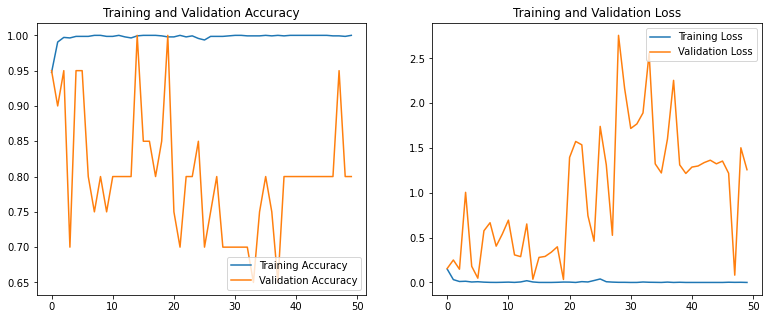

In [6]:
epochs = 50
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Aug

In [4]:
train_datagen = ImageDataGenerator(
                    rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
#                      vertical_flip=True,
                     shear_range=0.2,
                     zoom_range=0.2,
                     brightness_range=(0.5, 1.3),
                     fill_mode="nearest",
                    preprocessing_function= preprocess_input,
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

train_dir='/home/D000017244/nasdata/mask_workshop/train/'
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(image_size,image_size),
        batch_size=16,
        )
validation_dir='/home/D000017244/nasdata/mask_workshop/test/'
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=20,
        )

Found 1372 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [5]:
#2 classes Aug
history = model.fit_generator(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      class_weight='auto',
      shuffle = True,
      verbose=1)


Epoch 1/50
86/86 [==============================] - 23s 273ms/step - loss: 0.1832 - accuracy: 0.9351 - val_loss: 0.2979 - val_accuracy: 0.8500
Epoch 2/50
86/86 [==============================] - 19s 220ms/step - loss: 0.0487 - accuracy: 0.9840 - val_loss: 0.4183 - val_accuracy: 0.7000
Epoch 3/50
86/86 [==============================] - 20s 229ms/step - loss: 0.0445 - accuracy: 0.9847 - val_loss: 0.5653 - val_accuracy: 0.8000
Epoch 4/50
86/86 [==============================] - 20s 231ms/step - loss: 0.0191 - accuracy: 0.9927 - val_loss: 0.4042 - val_accuracy: 0.8000
Epoch 5/50
86/86 [==============================] - 20s 228ms/step - loss: 0.0226 - accuracy: 0.9913 - val_loss: 0.3642 - val_accuracy: 0.8500
Epoch 6/50
86/86 [==============================] - 20s 227ms/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 0.5094 - val_accuracy: 0.8500
Epoch 7/50
86/86 [==============================] - 20s 228ms/step - loss: 0.0095 - accuracy: 0.9964 - val_loss: 0.2856 - val_accuracy: 0.900

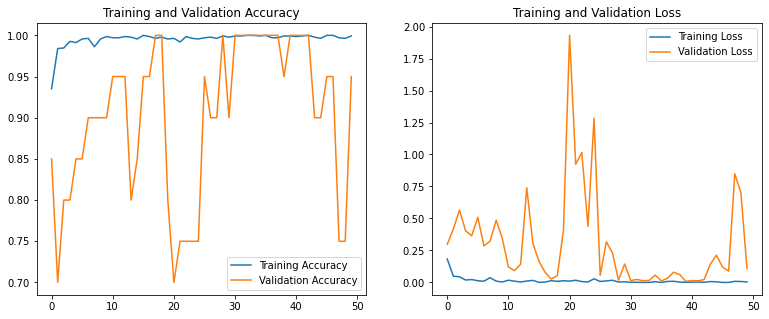

In [6]:
epochs = 50
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()